### Part 0: Cellular Automata Model On Network Structure


Cellular automata is discrete dynamical system in space and time consisting of a set of scattered cellular in analog space. Every state in the time sequence of cellular in every moment, is synchronize updated by cells around on the last time via same effect rules (local rules).

In the information diffusion process in social networks, cell of cellular automata can be assumed to be a individual member of the network (node), and cellular space can be assumed as the entire network. Cellular state parameters can be described as the individual characteristic parameters of a member state, cellular automata neighbors represents the range of individual members interaction.

For the purpose of modelling information diffusion, we define the following 3 states:

    Healthy: Person yet to come in contact with the information/ rumour

    Transmission: Person who believes the rumour

    Immune: Person who does not believe the rumour but might become a transmission node if contacted by multiple transmission nodes 


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import copy

In [6]:
# States
HEALTH = 0
TRANSMISSION = 1
IMMUNE = 2 # immune & inactive

class social_network():
    def __init__(self,  alpha=0.1,beta=0.3, n = 4000,name = "ws",):
        # Generation of random graphs
        if name == "ws":# Watts–Strogatz Graph
            self.graph = nx.watts_strogatz_graph(n, k = 57, p=0.5)
        elif name == "ba":# Barabási–Albert Graph
            self.graph = nx.barabasi_albert_graph(n, m = 6)
        init_dist=np.random.choice([TRANSMISSION,IMMUNE,HEALTH],
                         size = n,p=(alpha,beta,1-alpha-beta))
        # list of nodes group by status
        self.healthy_list = np.where(init_dist==HEALTH)[0].tolist()
        self.transmission_list = np.where(init_dist==TRANSMISSION)[0].tolist()
        self.immmune_list = np.where(init_dist==IMMUNE)[0].tolist()
        for i in range(0,n):
            self.graph.node[i]['status'] = init_dist[i]
            
            
    def recording_changing_immune(self):
        # recording the immune node that will be changed to transmission node
        
        g = self.graph
        im_to_be_changed_to_trans = []
        for ni in self.immmune_list:
            immune_neighbors = np.array(g.neighbors(ni))
            immune_neighbors_status = np.array([g.node[nei]['status'] 
                                                for nei in g.neighbors(ni)])
            # computing the probability for one immune node becoming transmission node
            p2 = len(immune_neighbors[np.where(
                immune_neighbors_status == TRANSMISSION)[0]]) / len(immune_neighbors)
            if np.random.uniform(0,1) < p2*0.1:
                im_to_be_changed_to_trans.append(ni)
        
        return im_to_be_changed_to_trans
    
    
    def changing_transmission_and_healthy(self, p1):
        # finish the (transmission ==> immune) & (healthy ==> transmission)
        # p1: the probability for transmission node affecting its neighbors
        g = self.graph
        for nt in self.transmission_list:
            neighbors = np.array(g.neighbors(nt))
            neighbors_status = np.array([g.node[nei]['status'] 
                                         for nei in g.neighbors(nt)])
            healthy_neighbors = neighbors[np.where(neighbors_status == HEALTH)[0]]
            spreaded_neighbors = healthy_neighbors[np.where(np.random.uniform(0,1,(healthy_neighbors.shape[0],)) 
                                      < p1)[0]]
            if spreaded_neighbors.size!=0:    # if information has spread to the neighbors of the transmission node
                self.transmission_list.remove(nt)
                self.immmune_list.append(nt)
                g.node[nt]['status'] = IMMUNE
                for sn in spreaded_neighbors:
                    self.healthy_list.remove(sn)
                    self.transmission_list.append(sn)
                    g.node[sn]['status'] = TRANSMISSION
              
            
    def changing_immune(self, im_to_be_changed_to_trans): 
        # transform the recorded immune nodes' status
        g = self.graph
        for ni in im_to_be_changed_to_trans:
            g.node[ni]['status'] = TRANSMISSION
            self.immmune_list.remove(ni)
            self.transmission_list.append(ni)
    
    
    def one_step(self, p1):
        g = self.graph
        # Conflicts Resolving Strategy:
        # first record the immune nodes that would change to be transmission,
        # but not actually change the status
        im_to_be_changed_to_trans = self.recording_changing_immune()
        self.changing_transmission_and_healthy(p1)
        self.changing_immune(im_to_be_changed_to_trans)
        return (len(self.healthy_list), len(self.transmission_list), len(self.immmune_list))
    
    def iteration(self, n = 100, p1 = 0.5):
        # using the counting list to record the nodes' number in every iteration
        cnt_list=[(len(self.healthy_list), 
                   len(self.transmission_list), 
                   len(self.immmune_list))]
        for i in range(n - 1):
            cnt_list.append(self.one_step(p1))
        return cnt_list


In [9]:
# simulation with a random BA graph
SN = social_network(name ="ba",alpha=0.1,beta=0.3, n = 4039)
iteration_num = 100
records=np.array(SN.iteration(n = iteration_num))

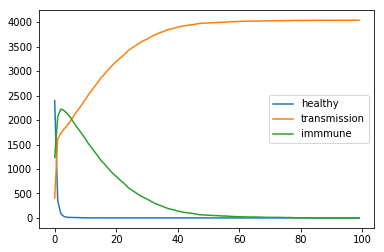

In [10]:
# plotting the simulation result
x=list(range(0,iteration_num))
plt.plot(x, records[:,0].tolist(),label="healthy")
plt.plot(x, records[:,1].tolist(),label="transmission")
plt.plot(x, records[:,2].tolist(),label="immmune")
plt.legend()